# Robot Vision Notebook (COMP34212)

In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-04-16 16:07:22.997864: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 16:07:23.045223: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 16:07:23.045247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 16:07:23.046161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 16:07:23.052859: I tensorflow/core/platform/cpu_feature_guar

In [2]:
tf.keras.backend.clear_session()
tf.config.run_functions_eagerly(True)

### Global Constants & Variables

In [3]:
# Image
IMAGES_PATH = "icub"
IMG_CHANNELS = 3
IMG_DOWNSCALE_FACTOR = 4
IMG_ROWS = int(256/IMG_DOWNSCALE_FACTOR)
IMG_COLS = int(256/IMG_DOWNSCALE_FACTOR)
N_CLASSES = len(os.listdir(IMAGES_PATH))

# Training
BATCH_SIZE = 32 
N_EPOCH = 25
VERBOSE = 1
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.001
OPTIM = Adam(LEARNING_RATE)

### Data Pre-Processing

In [4]:
objects = os.listdir(IMAGES_PATH)
mapping = {object_name: object_index for object_index, object_name in enumerate(objects)}
print(mapping)

{'ringbinder': 0, 'hairclip': 1, 'pencilcase': 2, 'wallet': 3, 'cellphone': 4, 'book': 5, 'hairbrush': 6, 'perfume': 7, 'sunglasses': 8, 'mouse': 9}


In [5]:
# Input images
image_dataset_x = []
image_dataset_y = []

def load_images(path, downscale_factor):
    """Cycles through folder structure inputting images and classifications to x and y lists and downsamples image by given factor"""
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            # Avoids listed folders and continues searching
            if item_path.split("/")[-1] not in ["ROT2D", "ROT3D", "SCALE", "TRANSL", "right"]: # folders to avoid
                load_images(item_path, downscale_factor)
        else:
            # If not a folder, checks for 26x256 jpg, downsamples, saves to x and y
            if item_path.endswith(".jpg"):
                image = cv2.imread(item_path)
                if image.shape == (256, 256, 3):
                    downsampled_image = cv2.resize(image, None, fx=1/downscale_factor, fy=1/downscale_factor)
                    image_dataset_x.append(downsampled_image)
                    category = item_path.split("/")[1] # swap to "\\" if using windows
                    image_dataset_y.append(mapping.get(category))
                    print(item_path)

load_images(IMAGES_PATH, IMG_DOWNSCALE_FACTOR)

icub/ringbinder/ringbinder7/MIX/day4/left/00001618.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001627.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001762.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001661.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001632.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001675.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001788.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001596.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001595.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001552.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001636.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001725.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001574.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001644.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001704.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001581.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001735.jpg
icub/ringbinder/ringbinder7/MIX/day4/left/00001589.jpg
icub/ringb

In [6]:
# Convert lists into np.arrays
image_dataset_x = np.array(image_dataset_x)
image_dataset_y = np.array(image_dataset_y)

In [7]:
# Print shapes of both np arrays
print(image_dataset_x.shape)
print(image_dataset_y.shape)

(61045, 64, 64, 3)
(61045,)


In [8]:
# Print distribution of classes
counts = np.unique(image_dataset_y, return_counts=True)
for i in range(N_CLASSES):
    print(f"{list(mapping.keys())[i]}: {counts[1][i]}")

ringbinder: 5363
hairclip: 6736
pencilcase: 6734
wallet: 5410
cellphone: 5718
book: 6666
hairbrush: 6186
perfume: 6294
sunglasses: 5426
mouse: 6512


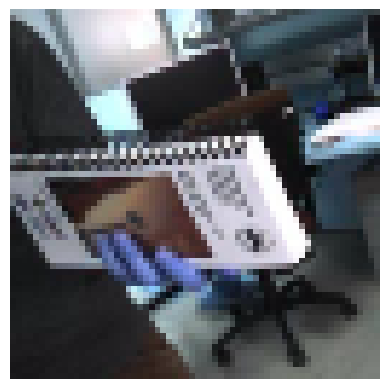

In [9]:
# Display sample image
plt.imshow(image_dataset_x[0])
plt.axis('off') 
plt.show()

In [10]:
# Split dataset into training and testing
input_X_train, input_X_test, output_y_train, output_y_test = train_test_split(image_dataset_x, image_dataset_y, test_size=0.2, random_state=42, stratify=image_dataset_y)

In [11]:
# Deletes extra sets from memory
del image_dataset_x
del image_dataset_y

In [12]:
# One-hot encode
output_Y_train = utils.to_categorical(output_y_train, N_CLASSES)
output_Y_test = utils.to_categorical(output_y_test, N_CLASSES) 

In [13]:
# Deletes extra sets from memory
del output_y_train
del output_y_test

In [14]:
# Normalise images
input_X_train = input_X_train.astype('float32')
input_X_test = input_X_test.astype('float32')
input_X_train /= 255
input_X_test /= 255

In [15]:
input_X_train.shape

(48836, 64, 64, 3)

### Model Construction, Training & Evaluation

In [16]:
# # Network definition

# model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
  
# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))

# model.add(Dense(N_CLASSES))
# model.add(Activation('softmax'))

In [17]:
# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
# model.summary()

In [18]:
# Complex DNN model definition
model = Sequential()
 
model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(Conv2D(32, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Conv2D(64, kernel_size=3, padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))


#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                        

2024-04-15 20:55:12.965064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 20:55:12.985974: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 20:55:12.986101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [20]:
# Training/fitting of the DNN model
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5


2024-04-15 20:55:17.321613: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-15 20:55:17.364829: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-15 20:55:17.545530: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 29s 23ms/step - loss: 1.5967 - accuracy: 0.4232 - val_loss: 0.9815 - val_accuracy: 0.6502
Epoch 2/5
1221/1221 [==============================] - 26s 21ms/step - loss: 0.8971 - accuracy: 0.6762 - val_loss: 0.6576 - val_accuracy: 0.7673
Epoch 3/5
1221/1221 [==============================] - 25s 21ms/step - loss: 0.6544 - accuracy: 0.7640 - val_loss: 0.4574 - val_accuracy: 0.8394
Epoch 4/5
1221/1221 [==============================] - 25s 21ms/step - loss: 0.5247 - accuracy: 0.8122 - val_loss: 0.4093 - val_accuracy: 0.8614
Epoch 5/5
1221/1221 [==============================] - 25s 21ms/step - loss: 0.4631 - accuracy: 0.8359 - val_loss: 0.3440 - val_accuracy: 0.8854


382/382 [==============================] - 4s 9ms/step - loss: 0.3413 - accuracy: 0.8831

Test score/loss: 0.3413279056549072
Test accuracy: 0.8831189870834351
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


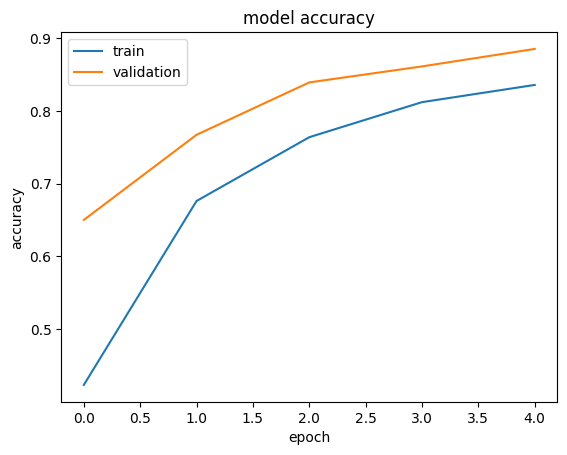

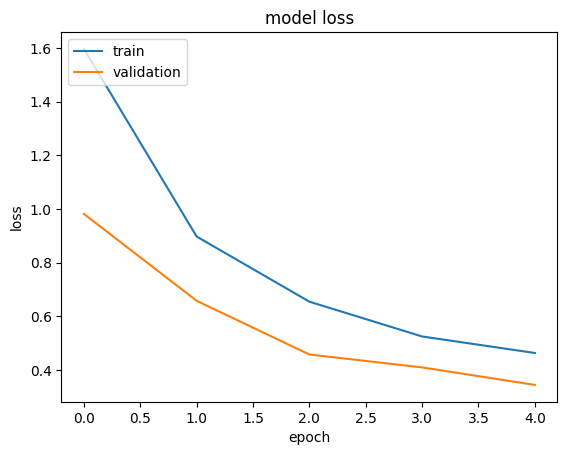

In [21]:
# Testing
score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score/loss:", score[0])
print('Test accuracy:', score[1])

# List all data in history
print(history.history.keys())

# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
# Calculates testing predictions
predictions = model.predict(input_X_test)

382/382 [==============================] - 1s 2ms/step


Text(0.5, 1.0, 'Correlation Matrix')

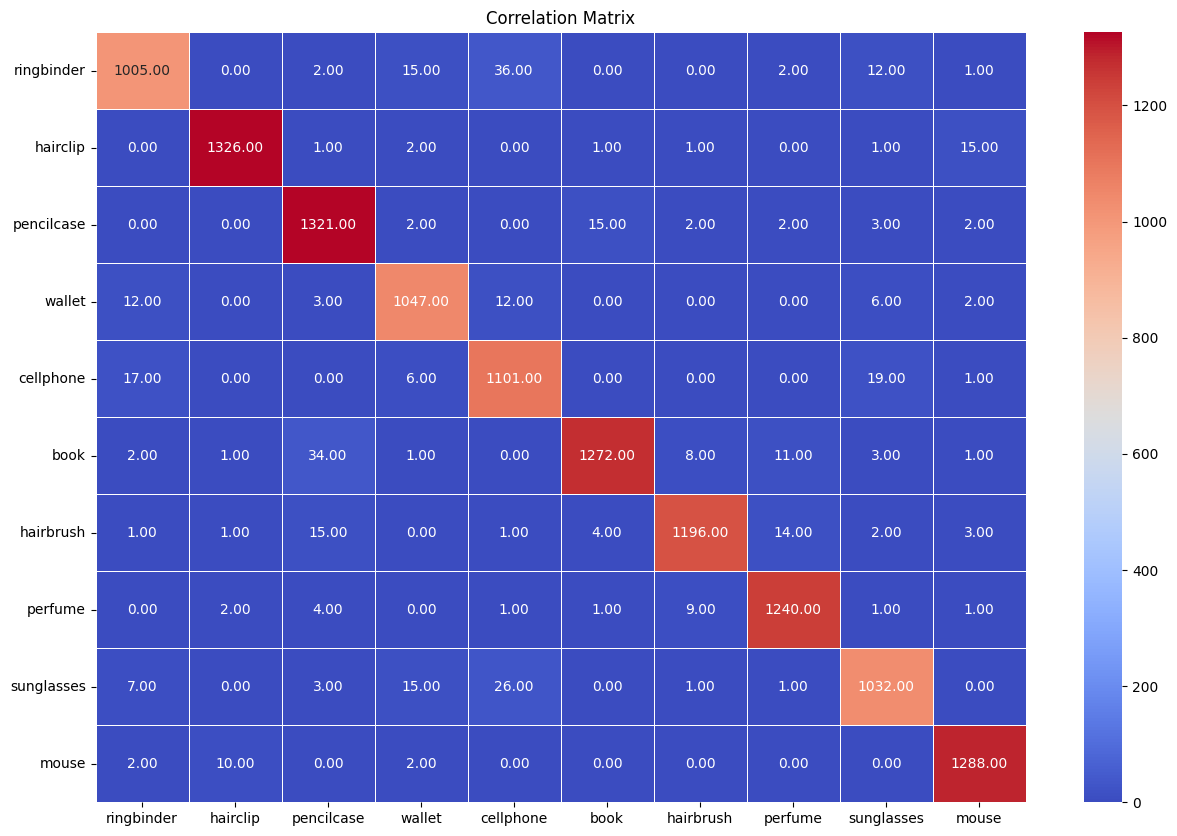

In [22]:
# Calculates and displays confusion matrix
cm = confusion_matrix(np.argmax(output_Y_test, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, xticklabels=objects, yticklabels=objects) 
plt.yticks(rotation=0)
plt.title('Correlation Matrix')

### Network Topology Experimentation (Common CNN Architecture Tests)

In [16]:
def model_evaluation(model):
    score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print("\nTest score/loss:", score[0])
    print('Test accuracy:', score[1])

    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [25]:
class LeNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()

		# CONV => RELU => POOL
		model.add(Conv2D(20, kernel_size=5, padding="same", input_shape=input_shape))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

		# CONV => RELU => POOL
		model.add(Conv2D(50, kernel_size=5, padding="same"))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

		# Flatten => RELU layers
		model.add(Flatten())
		model.add(Dense(500))
		model.add(Activation("relu"))

		# a softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		return model

In [17]:
model = LeNet.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 20)        1520      
                                                                 
 activation (Activation)     (None, 64, 64, 20)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 20)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 50)        25050     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 50)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 50)        0         
 g2D)                                                   

2024-04-16 12:07:07.376574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 12:07:07.401267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 12:07:07.401392: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-16 12:07:13.609886: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 12:07:13.647670: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 12:07:13.845750: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 20s 15ms/step - loss: 1.2632 - accuracy: 0.5482 - val_loss: 0.7944 - val_accuracy: 0.7167
Epoch 2/25
1221/1221 [==============================] - 18s 15ms/step - loss: 0.4593 - accuracy: 0.8427 - val_loss: 0.5109 - val_accuracy: 0.8317
Epoch 3/25
1221/1221 [==============================] - 18s 15ms/step - loss: 0.1725 - accuracy: 0.9424 - val_loss: 0.4507 - val_accuracy: 0.8597
Epoch 4/25
1221/1221 [==============================] - 18s 14ms/step - loss: 0.0820 - accuracy: 0.9726 - val_loss: 0.5768 - val_accuracy: 0.8507
Epoch 5/25
1221/1221 [==============================] - 17s 14ms/step - loss: 0.0584 - accuracy: 0.9805 - val_loss: 0.6134 - val_accuracy: 0.8640
Epoch 6/25
1221/1221 [==============================] - 18s 14ms/step - loss: 0.0543 - accuracy: 0.9814 - val_loss: 0.6535 - val_accuracy: 0.8632
Epoch 7/25
1221/1221 [==============================] - 17s 14ms/step - loss: 0.0490 - accuracy: 0.9847 - val_loss: 0.6939 - val_accura

382/382 [==============================] - 3s 8ms/step - loss: 1.3725 - accuracy: 0.8629

Test score/loss: 1.3725382089614868
Test accuracy: 0.8628880381584167
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


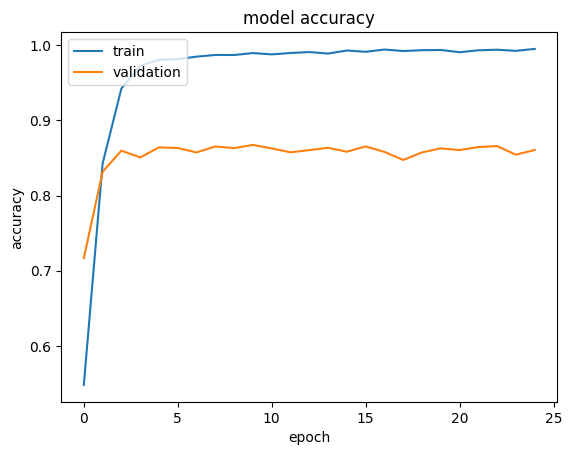

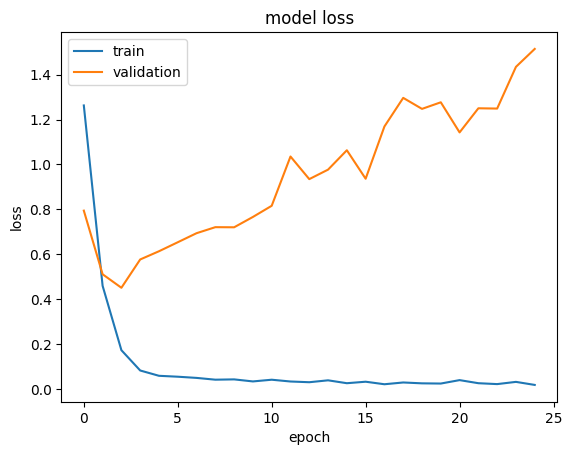

In [22]:
model_evaluation(model)

In [17]:
class AlexNet:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()

		model.add(Conv2D(96, kernel_size=11, strides=(4, 4), activation="ReLU", padding="valid", input_shape=input_shape))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(256, kernel_size=5, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(384, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(384, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(384, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))

		model.add(Flatten())
		model.add(Dense(4096, activation="ReLU"))
		model.add(Dense(4096, activation="ReLU"))
		model.add(Dense(classes, activation="softmax"))

		return model

In [18]:
model = AlexNet.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()


2024-04-16 16:07:51.881771: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:07:51.901371: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:07:51.901501: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 96)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 256)         614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 384)         1

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 16:07:53.295656: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 16:07:53.337270: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 16:07:53.493422: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 26s 20ms/step - loss: 2.2997 - accuracy: 0.1092 - val_loss: 2.2993 - val_accuracy: 0.1080
Epoch 2/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2991 - accuracy: 0.1083 - val_loss: 2.2995 - val_accuracy: 0.1070
Epoch 3/25
1221/1221 [==============================] - 24s 19ms/step - loss: 2.2988 - accuracy: 0.1093 - val_loss: 2.2996 - val_accuracy: 0.1070
Epoch 4/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2988 - accuracy: 0.1094 - val_loss: 2.2996 - val_accuracy: 0.1070
Epoch 5/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2988 - accuracy: 0.1079 - val_loss: 2.2993 - val_accuracy: 0.1070
Epoch 6/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2987 - accuracy: 0.1096 - val_loss: 2.2994 - val_accuracy: 0.1070
Epoch 7/25
1221/1221 [==============================] - 23s 19ms/step - loss: 2.2987 - accuracy: 0.1099 - val_loss: 2.2992 - val_accura

382/382 [==============================] - 4s 10ms/step - loss: 2.2986 - accuracy: 0.1103

Test score/loss: 2.298635244369507
Test accuracy: 0.11032844334840775
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


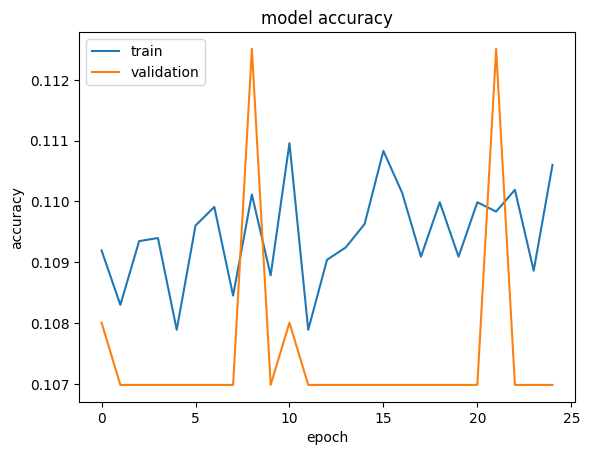

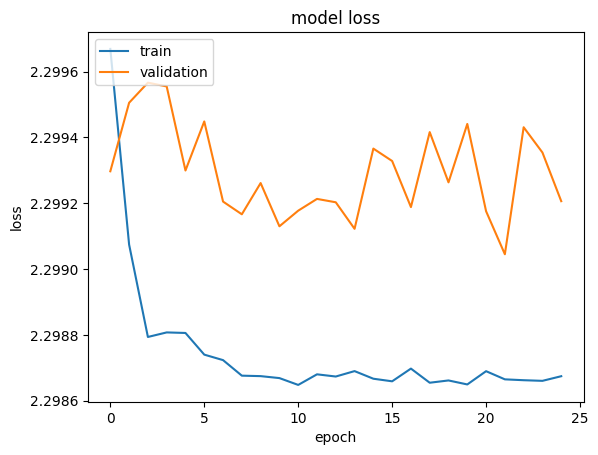

In [20]:
model_evaluation(model)

In [17]:
class AlexNetModifiedOne:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()

		model.add(Conv2D(50, kernel_size=11, strides=(4, 4), activation="ReLU", padding="valid", input_shape=input_shape))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(75, kernel_size=5, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(100, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(100, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(100, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))

		model.add(Flatten())
		model.add(Dense(500, activation="ReLU"))
		model.add(Dense(500, activation="ReLU"))
		model.add(Dense(classes, activation="softmax"))

		return model

In [18]:
model = AlexNetModifiedOne.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 50)        18200     
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 50)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 75)          93825     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 75)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 100)         67600     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 100)         9

2024-04-16 14:59:04.044963: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 14:59:04.064204: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 14:59:04.064345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 14:59:07.869752: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 14:59:07.906658: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 14:59:08.055469: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 25s 19ms/step - loss: 1.9382 - accuracy: 0.2665 - val_loss: 1.6313 - val_accuracy: 0.3898
Epoch 2/25
1221/1221 [==============================] - 23s 19ms/step - loss: 1.4494 - accuracy: 0.4694 - val_loss: 1.3280 - val_accuracy: 0.5270
Epoch 3/25
1221/1221 [==============================] - 23s 19ms/step - loss: 1.1898 - accuracy: 0.5673 - val_loss: 1.1814 - val_accuracy: 0.5746
Epoch 4/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.9958 - accuracy: 0.6416 - val_loss: 1.0148 - val_accuracy: 0.6432
Epoch 5/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.8520 - accuracy: 0.6976 - val_loss: 0.8961 - val_accuracy: 0.6815
Epoch 6/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.7333 - accuracy: 0.7413 - val_loss: 0.8221 - val_accuracy: 0.7119
Epoch 7/25
1221/1221 [==============================] - 22s 18ms/step - loss: 0.6395 - accuracy: 0.7778 - val_loss: 0.7976 - val_accura

382/382 [==============================] - 3s 9ms/step - loss: 0.7481 - accuracy: 0.8154

Test score/loss: 0.7481114864349365
Test accuracy: 0.8153821229934692
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


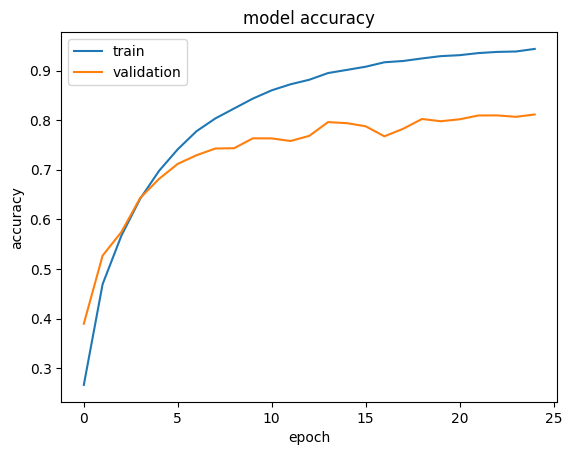

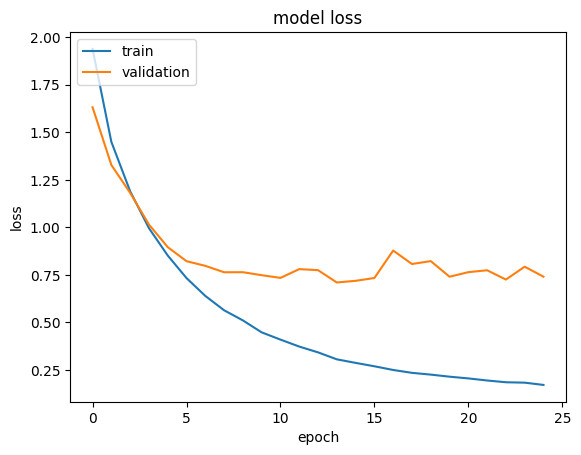

In [20]:
model_evaluation(model)

In [17]:
class AlexNetModifiedTwo:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()

		model.add(Conv2D(32, kernel_size=11, strides=(4, 4), activation="ReLU", padding="valid", input_shape=input_shape))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(64, kernel_size=5, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(96, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(96, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(96, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))

		model.add(Flatten())
		model.add(Dense(512, activation="ReLU"))
		model.add(Dense(512, activation="ReLU"))
		model.add(Dense(classes, activation="softmax"))

		return model

In [18]:
model = AlexNetModifiedTwo.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        11648     
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 96)          55392     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 96)          8

2024-04-16 15:12:21.709677: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:12:21.730543: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:12:21.730661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 15:12:24.778314: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 15:12:24.815418: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 15:12:24.964614: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 25s 20ms/step - loss: 1.9128 - accuracy: 0.2800 - val_loss: 1.5470 - val_accuracy: 0.4087
Epoch 2/25
1221/1221 [==============================] - 23s 19ms/step - loss: 1.3641 - accuracy: 0.4890 - val_loss: 1.2694 - val_accuracy: 0.5349
Epoch 3/25
1221/1221 [==============================] - 23s 19ms/step - loss: 1.0726 - accuracy: 0.6044 - val_loss: 1.0640 - val_accuracy: 0.6247
Epoch 4/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.8864 - accuracy: 0.6769 - val_loss: 0.9051 - val_accuracy: 0.6745
Epoch 5/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.7434 - accuracy: 0.7322 - val_loss: 0.8244 - val_accuracy: 0.6996
Epoch 6/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.6330 - accuracy: 0.7761 - val_loss: 0.7512 - val_accuracy: 0.7379
Epoch 7/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.5509 - accuracy: 0.8063 - val_loss: 0.7068 - val_accura

382/382 [==============================] - 4s 9ms/step - loss: 0.7117 - accuracy: 0.8283

Test score/loss: 0.7117161154747009
Test accuracy: 0.8283233642578125
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


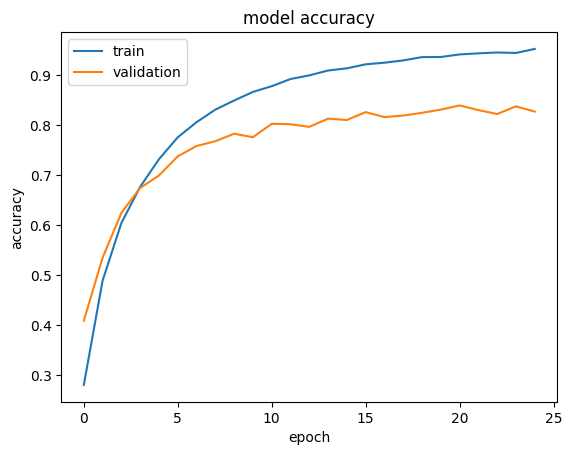

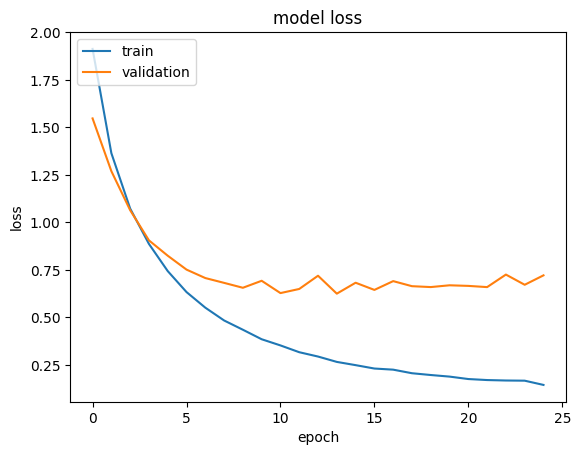

In [20]:
model_evaluation(model)

In [17]:
class AlexNetModifiedThree:
	@staticmethod
	def build(input_shape, classes):
		model = Sequential()

		model.add(Conv2D(20, kernel_size=11, strides=(4, 4), activation="ReLU", padding="valid", input_shape=input_shape))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(40, kernel_size=5, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="valid"))

		model.add(Conv2D(80, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(80, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))
		model.add(Conv2D(80, kernel_size=3, strides=(1, 1), activation="ReLU", padding="same"))

		model.add(Flatten())
		model.add(Dense(240, activation="ReLU"))
		model.add(Dense(240, activation="ReLU"))
		model.add(Dense(classes, activation="softmax"))

		return model

In [18]:
model = AlexNetModifiedThree.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 20)        7280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 6, 20)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 40)          20040     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 2, 2, 40)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 80)          28880     
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 80)          5

2024-04-16 15:25:49.661372: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:25:49.683165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:25:49.683283: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 15:25:53.110449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 15:25:53.148392: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 15:25:53.304021: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 25s 19ms/step - loss: 1.9985 - accuracy: 0.2516 - val_loss: 1.7212 - val_accuracy: 0.3696
Epoch 2/25
1221/1221 [==============================] - 23s 19ms/step - loss: 1.5447 - accuracy: 0.4361 - val_loss: 1.4398 - val_accuracy: 0.4803
Epoch 3/25
1221/1221 [==============================] - 23s 19ms/step - loss: 1.2919 - accuracy: 0.5279 - val_loss: 1.2559 - val_accuracy: 0.5492
Epoch 4/25
1221/1221 [==============================] - 23s 19ms/step - loss: 1.1106 - accuracy: 0.5991 - val_loss: 1.1410 - val_accuracy: 0.5926
Epoch 5/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.9869 - accuracy: 0.6466 - val_loss: 1.0738 - val_accuracy: 0.6175
Epoch 6/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.8738 - accuracy: 0.6874 - val_loss: 0.9836 - val_accuracy: 0.6574
Epoch 7/25
1221/1221 [==============================] - 23s 19ms/step - loss: 0.7793 - accuracy: 0.7226 - val_loss: 0.9425 - val_accura

382/382 [==============================] - 4s 9ms/step - loss: 0.9552 - accuracy: 0.7682

Test score/loss: 0.9551796913146973
Test accuracy: 0.7682037949562073
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


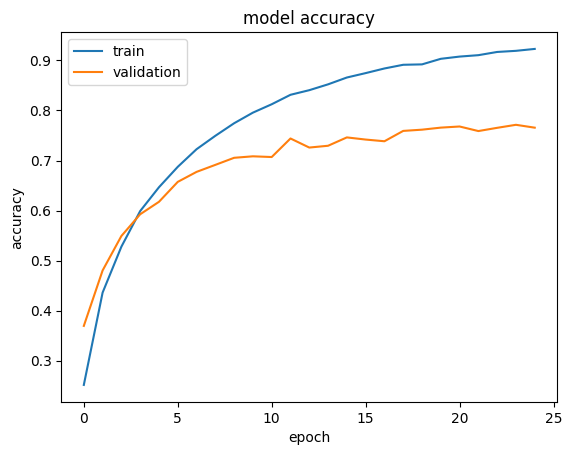

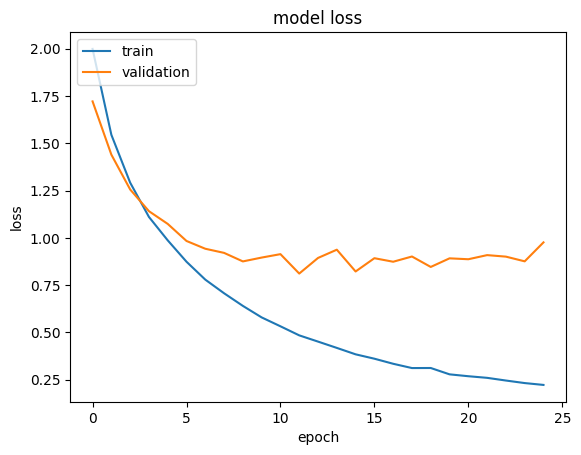

In [20]:
model_evaluation(model)

In [17]:
class DeepCNN:
        @staticmethod
        def build(input_shape, classes):
                model = Sequential()
                
                model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=input_shape))
                model.add(Activation('relu'))
                model.add(Conv2D(32, kernel_size=3, padding='same'))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))
                # model.add(Dropout(0.25))

                model.add(Conv2D(64, kernel_size=3, padding='same'))
                model.add(Activation('relu'))
                model.add(Conv2D(64, 3, 3))
                model.add(Activation('relu'))
                model.add(MaxPooling2D(pool_size=(2, 2)))
                # model.add(Dropout(0.25))

                model.add(Flatten())
                model.add(Dense(512))
                model.add(Activation('relu'))
                # model.add(Dropout(0.5))
                model.add(Dense(classes))
                model.add(Activation('softmax'))

                return model

In [18]:
model = DeepCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                        

2024-04-16 15:43:42.679190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:43:42.698584: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 15:43:42.698693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [19]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/25


2024-04-16 15:43:44.186400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 15:43:44.225021: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 15:43:44.402199: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 23s 18ms/step - loss: 1.1706 - accuracy: 0.5812 - val_loss: 0.6056 - val_accuracy: 0.7819
Epoch 2/25
1221/1221 [==============================] - 21s 17ms/step - loss: 0.4286 - accuracy: 0.8504 - val_loss: 0.4078 - val_accuracy: 0.8577
Epoch 3/25
1221/1221 [==============================] - 20s 17ms/step - loss: 0.2222 - accuracy: 0.9227 - val_loss: 0.3324 - val_accuracy: 0.8916
Epoch 4/25
1221/1221 [==============================] - 20s 17ms/step - loss: 0.1403 - accuracy: 0.9528 - val_loss: 0.3945 - val_accuracy: 0.8793
Epoch 5/25
1221/1221 [==============================] - 20s 17ms/step - loss: 0.0971 - accuracy: 0.9670 - val_loss: 0.3107 - val_accuracy: 0.9123
Epoch 6/25
1221/1221 [==============================] - 21s 17ms/step - loss: 0.0823 - accuracy: 0.9722 - val_loss: 0.4153 - val_accuracy: 0.8897
Epoch 7/25
1221/1221 [==============================] - 20s 17ms/step - loss: 0.0670 - accuracy: 0.9782 - val_loss: 0.3242 - val_accura

382/382 [==============================] - 3s 9ms/step - loss: 0.4380 - accuracy: 0.9328

Test score/loss: 0.4379832446575165
Test accuracy: 0.9327545166015625
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


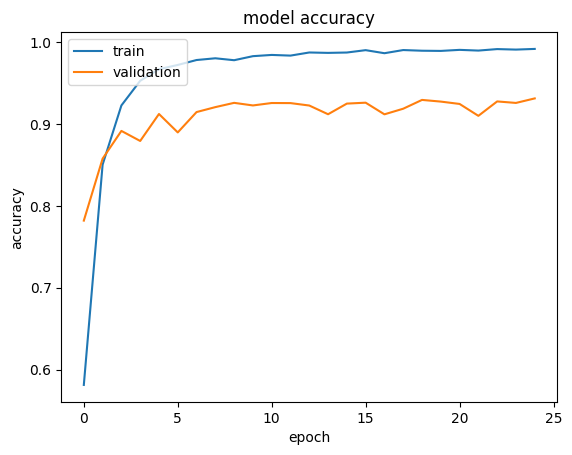

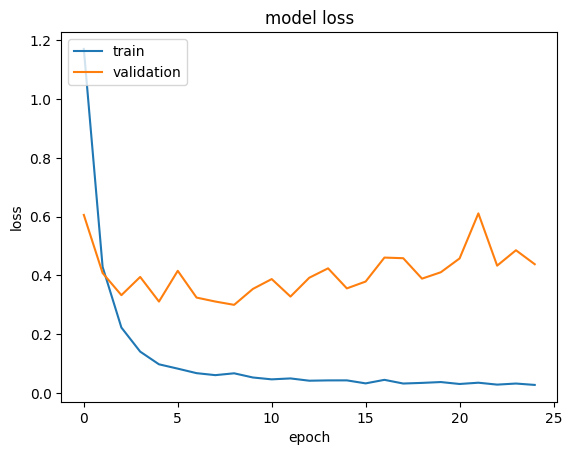

In [20]:
model_evaluation(model)

In [17]:
class SimpleCNN:
        @staticmethod
        def build(input_shape, classes):
            model = Sequential()

            model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            # model.add(Dropout(0.25))
            
            model.add(Flatten())
            model.add(Dense(512))
            model.add(Activation('relu'))
            # model.add(Dropout(0.5))

            model.add(Dense(classes))
            model.add(Activation('softmax'))

            return model

In [19]:
model = SimpleCNN.build(input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS), classes=N_CLASSES)

model.compile(loss="categorical_crossentropy", optimizer=OPTIM, metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               16777728  
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                        

2024-04-16 16:00:09.151102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:00:09.171315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 16:00:09.171430: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [20]:
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Epoch 1/25


/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 16:00:11.403009: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 16:00:11.441441: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 16:00:11.624984: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 17s 13ms/step - loss: 1.3437 - accuracy: 0.5352 - val_loss: 0.8863 - val_accuracy: 0.6943
Epoch 2/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.5640 - accuracy: 0.8078 - val_loss: 0.6528 - val_accuracy: 0.7754
Epoch 3/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.2551 - accuracy: 0.9174 - val_loss: 0.6482 - val_accuracy: 0.7934
Epoch 4/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.1078 - accuracy: 0.9676 - val_loss: 0.6628 - val_accuracy: 0.8088
Epoch 5/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0651 - accuracy: 0.9810 - val_loss: 0.7945 - val_accuracy: 0.8010
Epoch 6/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0519 - accuracy: 0.9841 - val_loss: 0.8331 - val_accuracy: 0.8025
Epoch 7/25
1221/1221 [==============================] - 16s 13ms/step - loss: 0.0422 - accuracy: 0.9861 - val_loss: 0.9260 - val_accura

382/382 [==============================] - 3s 7ms/step - loss: 1.8019 - accuracy: 0.7765

Test score/loss: 1.8019256591796875
Test accuracy: 0.7764763832092285
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


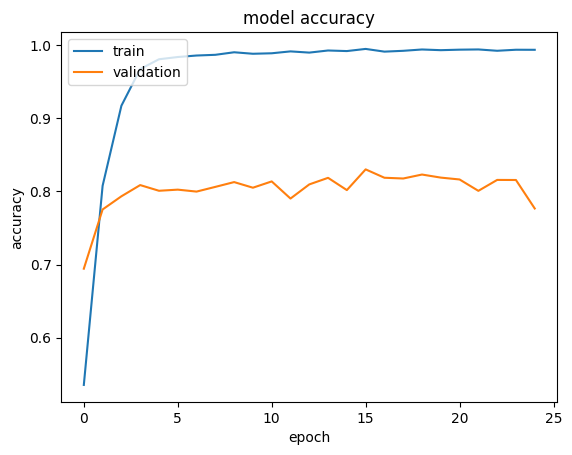

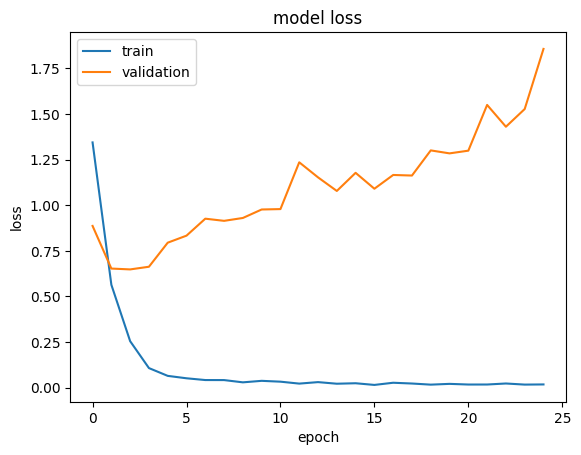

In [21]:
model_evaluation(model)

### Network Topology Experimentation

Try increasing number of layers

In [19]:
# Complex DNN model definition

def network_topology_definition(layer_count=1, kernel_size=3):
    """Creates CNN with customizable layer count and kernel size"""

    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=kernel_size, padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, kernel_size=kernel_size, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    for layer in range(layer_count):
        model.add(Conv2D(64, kernel_size=kernel_size, padding='same'))
        model.add(Activation('relu'))
        model.add(Conv2D(64, kernel_size=kernel_size, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(N_CLASSES))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

    print(model.summary())
    
    return model

In [21]:
# Test 1 (original)

model = network_topology_definition()
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 32)        0         
                                                      

382/382 [==============================] - 4s 10ms/step - loss: 0.1163 - accuracy: 0.9640

Test score/loss: 0.11634774506092072
Test accuracy: 0.9639610052108765
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


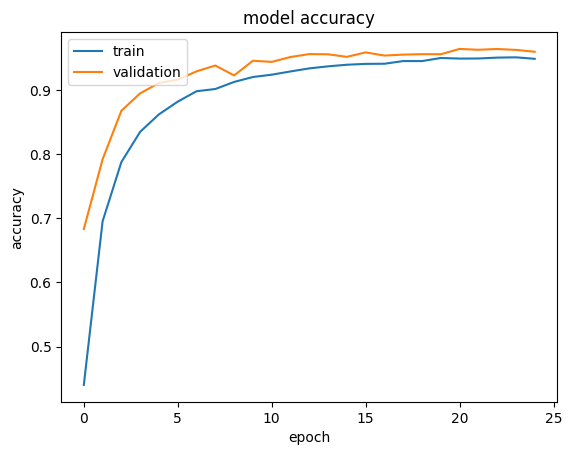

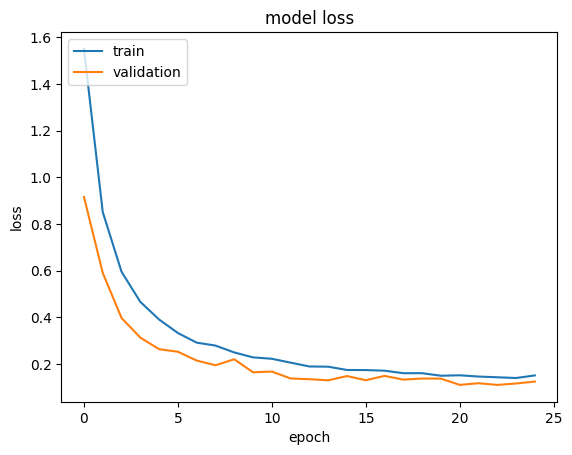

In [22]:
# Test 1 Output
model_evaluation(model)

In [20]:
# Test 2 (original + 1)

model = network_topology_definition(layer_count=2)
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)        0         
                                                      

/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2024-04-16 11:25:53.677948: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-16 11:25:53.792758: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 11:25:54.079727: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 32s 24ms/step - loss: 1.5073 - accuracy: 0.4541 - val_loss: 0.9448 - val_accuracy: 0.6491
Epoch 2/25
1221/1221 [==============================] - 28s 23ms/step - loss: 0.7824 - accuracy: 0.7147 - val_loss: 0.5614 - val_accuracy: 0.8063
Epoch 3/25
1221/1221 [==============================] - 28s 23ms/step - loss: 0.5327 - accuracy: 0.8107 - val_loss: 0.4283 - val_accuracy: 0.8523
Epoch 4/25
1221/1221 [==============================] - 28s 23ms/step - loss: 0.4204 - accuracy: 0.8522 - val_loss: 0.3218 - val_accuracy: 0.8879
Epoch 5/25
1221/1221 [==============================] - 28s 23ms/step - loss: 0.3274 - accuracy: 0.8871 - val_loss: 0.2419 - val_accuracy: 0.9166
Epoch 6/25
1221/1221 [==============================] - 27s 22ms/step - loss: 0.2913 - accuracy: 0.8996 - val_loss: 0.2428 - val_accuracy: 0.9187
Epoch 7/25
1221/1221 [==============================] - 28s 23ms/step - loss: 0.2543 - accuracy: 0.9125 - val_loss: 0.2113 - val_accura

382/382 [==============================] - 4s 10ms/step - loss: 0.1234 - accuracy: 0.9616

Test score/loss: 0.1233796626329422
Test accuracy: 0.9615857005119324
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


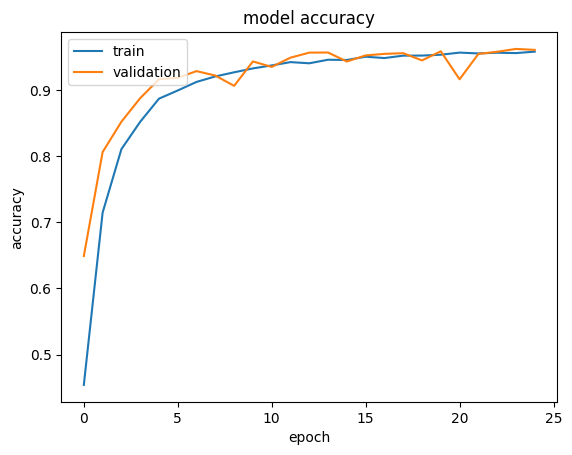

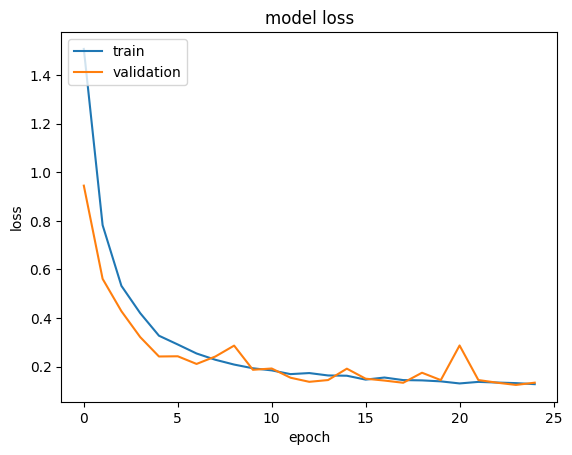

In [21]:
# Test 2 Output
model_evaluation(model)

In [22]:
# Test 2 (original + 2)

model = network_topology_definition(layer_count=3)
history = model.fit(input_X_train, output_Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 activation_14 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 activation_15 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 32, 32, 32)        0         
                                                      

  6/382 [..............................] - ETA: 4s - loss: 2.2882 - accuracy: 0.1719

/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


382/382 [==============================] - 4s 11ms/step - loss: 2.2987 - accuracy: 0.1103

Test score/loss: 2.29866361618042
Test accuracy: 0.11032844334840775
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


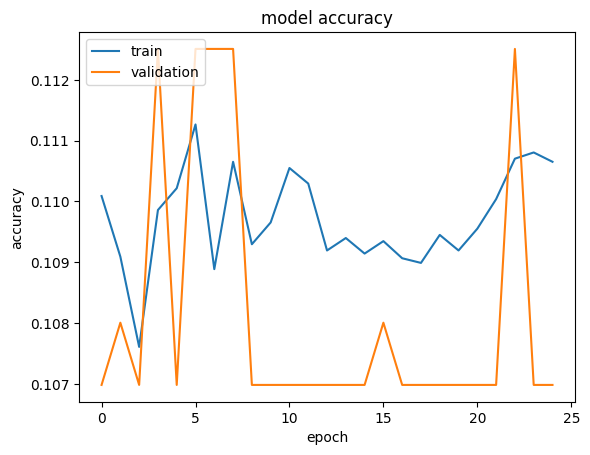

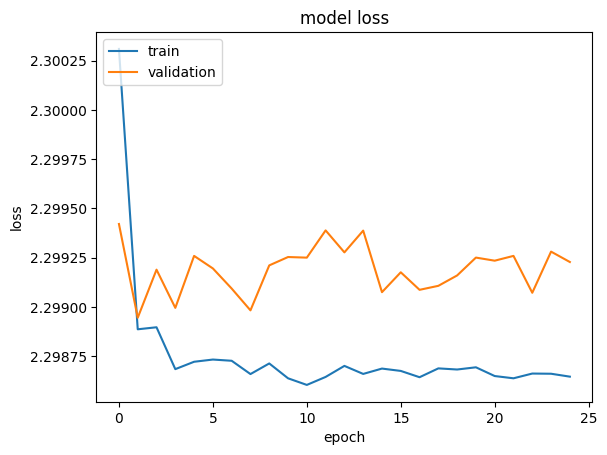

In [23]:
# Test 3 Output
model_evaluation(model)

### Network Hyperparameters Experimentation

In [18]:
# Model architecture used for hyperparameter training

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
  
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))

2024-04-15 20:20:50.529464: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 20:20:50.550526: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 20:20:50.550642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
def hyperparameter_test(epochs, learning_rate, batch_size):
    print(f"LEARNING RATE: {learning_rate}\n")
    
    tf.keras.backend.clear_session()

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

    history = model.fit(input_X_train, output_Y_train, batch_size=batch_size, epochs=epochs, validation_split=VALIDATION_SPLIT,  verbose=VERBOSE)

    # Testing
    score = model.evaluate(input_X_test, output_Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print("\nTest score/loss:", score[0])
    print('Test accuracy:', score[1])

    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    print("END OF EXPERIMENT\n")

    return score

##### Learning Rate Testing (Run separatly due to GPU memory constraints)

LEARNING RATE: 0.1

Epoch 1/50
1221/1221 [==============================] - 20s 17ms/step - loss: 2.3117 - accuracy: 0.1037 - val_loss: 2.3130 - val_accuracy: 0.1125
Epoch 2/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.3110 - accuracy: 0.1075 - val_loss: 2.3109 - val_accuracy: 0.1125
Epoch 3/50
1221/1221 [==============================] - 19s 15ms/step - loss: 2.3118 - accuracy: 0.1059 - val_loss: 2.3352 - val_accuracy: 0.1080
Epoch 4/50
1221/1221 [==============================] - 19s 15ms/step - loss: 2.3114 - accuracy: 0.1062 - val_loss: 2.3142 - val_accuracy: 0.1070
Epoch 5/50
1221/1221 [==============================] - 19s 15ms/step - loss: 2.3119 - accuracy: 0.1021 - val_loss: 2.3084 - val_accuracy: 0.1125
Epoch 6/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.3107 - accuracy: 0.1060 - val_loss: 2.3047 - val_accuracy: 0.0996
Epoch 7/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.3116 - accuracy: 0.1078 

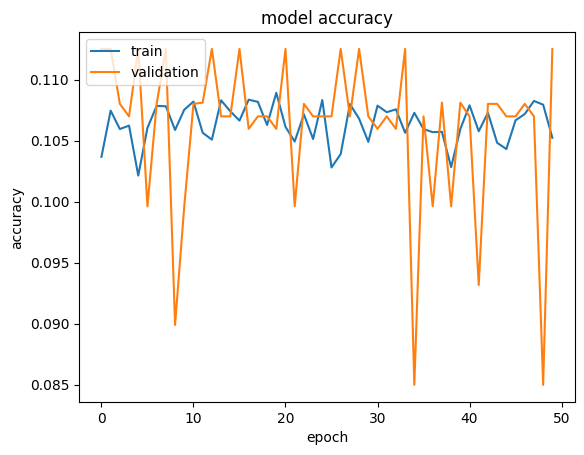

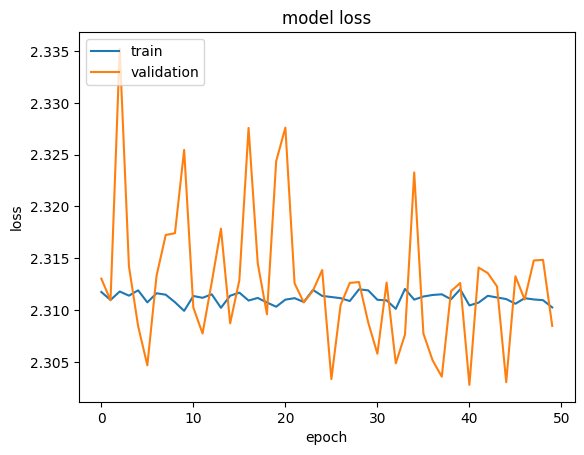

END OF EXPERIMENT



In [26]:
score = hyperparameter_test(N_EPOCH, 0.1, BATCH_SIZE)

LEARNING RATE: 0.01



/home/lior/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50


2024-04-15 20:21:08.418315: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-15 20:21:08.458247: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-15 20:21:08.637850: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1221/1221 [==============================] - 21s 17ms/step - loss: 2.3577 - accuracy: 0.1072 - val_loss: 2.3007 - val_accuracy: 0.1080
Epoch 2/50
1221/1221 [==============================] - 20s 16ms/step - loss: 2.3001 - accuracy: 0.1078 - val_loss: 2.2999 - val_accuracy: 0.1070
Epoch 3/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2996 - accuracy: 0.1102 - val_loss: 2.3008 - val_accuracy: 0.1060
Epoch 4/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2998 - accuracy: 0.1086 - val_loss: 2.3012 - val_accuracy: 0.1070
Epoch 5/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2999 - accuracy: 0.1086 - val_loss: 2.3010 - val_accuracy: 0.1080
Epoch 6/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2999 - accuracy: 0.1072 - val_loss: 2.2993 - val_accuracy: 0.1080
Epoch 7/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2998 - accuracy: 0.1083 - val_loss: 2.3013 - val_accura

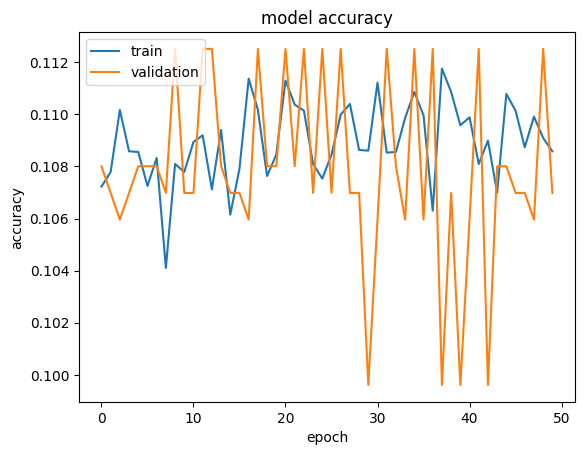

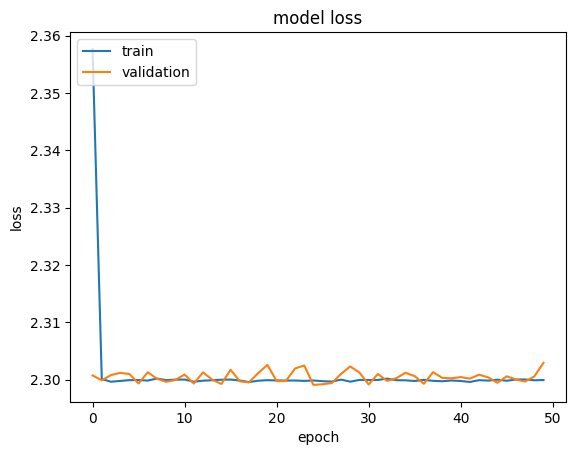

END OF EXPERIMENT



In [19]:
score = hyperparameter_test(N_EPOCH, 0.01, BATCH_SIZE)

LEARNING RATE: 0.001

Epoch 1/50
1221/1221 [==============================] - 20s 16ms/step - loss: 2.2992 - accuracy: 0.1104 - val_loss: 2.2993 - val_accuracy: 0.1070
Epoch 2/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2987 - accuracy: 0.1095 - val_loss: 2.2991 - val_accuracy: 0.1070
Epoch 3/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2987 - accuracy: 0.1114 - val_loss: 2.2993 - val_accuracy: 0.1070
Epoch 4/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2987 - accuracy: 0.1096 - val_loss: 2.2993 - val_accuracy: 0.1070
Epoch 5/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2987 - accuracy: 0.1099 - val_loss: 2.2991 - val_accuracy: 0.1070
Epoch 6/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2986 - accuracy: 0.1095 - val_loss: 2.2991 - val_accuracy: 0.1070
Epoch 7/50
1221/1221 [==============================] - 19s 16ms/step - loss: 2.2987 - accuracy: 0.110

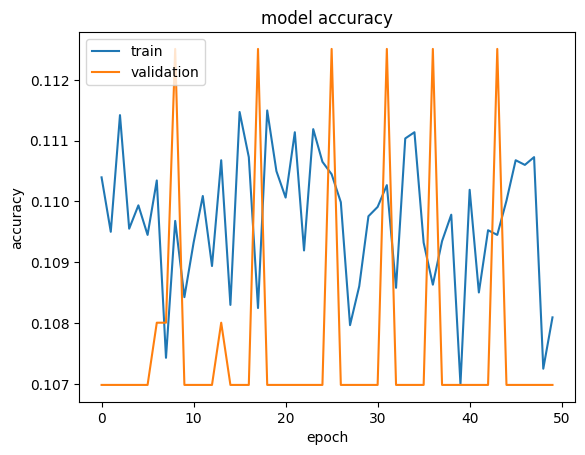

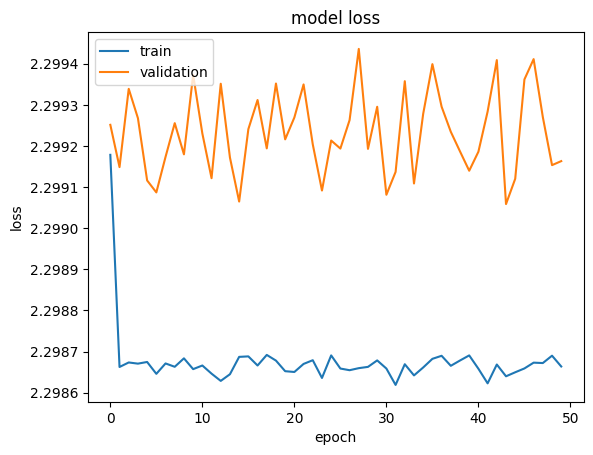

END OF EXPERIMENT



In [20]:
score = hyperparameter_test(N_EPOCH, 0.001, BATCH_SIZE)

In [ ]:
score = hyperparameter_test(N_EPOCH, 0.0001, BATCH_SIZE)